In [56]:
pip install missingno

In [57]:
import pandas as pd
import missingno as msno
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 1. Import the data.

Before importing, the data is convereted to a csv format from the gsheet format and stored on colab. Please update the path as the data is stored in my drive

In [77]:
# note that the data is stored in my personal drive, modify the path of the data if needed
path = "/content/drive/MyDrive/Colab Notebooks/RA_Data.csv"
df = pd.read_csv(path)

# 2. Describe the data available in the file.


## a. the shape of the data

In [59]:
print("The shape of the data is ", df.shape)

# there are 800 rows and 22 columns

The shape of the data is  (800, 22)


In [60]:
df.columns

Index(['Please name one charity you have given to in the last five years.',
       'Do you wish to give to [QID165-ChoiceTextEntryValue]? If you do, we will donate an amount you specify from your payment on your behalf.',
       'give_ind', 'How much do you wish to give?', 'amount',
       'Why did you choose to give?', 'Why did you choose not to give?',
       'Do you wish to give to another charity?',
       'I feel [QID165-ChoiceTextEntryValue] is grateful.', 'grateful_num',
       'I feel [QID165-ChoiceTextEntryValue] is greedy.', 'greedy_num',
       'recency', 'frequency', 'loyalty',
       'How much did you give each year, on average, to [QID165-ChoiceTextEntryValue]?',
       'monetary', 'What is your gender?', 'What is your age?',
       'What is your annual income?',
       'What is the highest degree or level of school you have completed? If currently enrolled, highest degree received.',
       'condition'],
      dtype='object')

## b. understand the missing value patterns of the data

In [61]:
# report num of missing value in different columns descendingly
missing_values = df.isnull().sum()
missing_values_df = pd.DataFrame(missing_values, columns=['Number of Missing Values'])
missing_values_df.index.name = 'Column'
missing_values_df.sort_values(by="Number of Missing Values", ascending=False)


,Number of Missing Values
Column,
Why did you choose not to give?,481
Do you wish to give to another charity?,481
How much do you wish to give?,319
Why did you choose to give?,319
monetary,12
Please name one charity you have given to in the last five years.,0
frequency,0
"What is the highest degree or level of school you have completed? If currently enrolled, highest degree received.",0
What is your annual income?,0


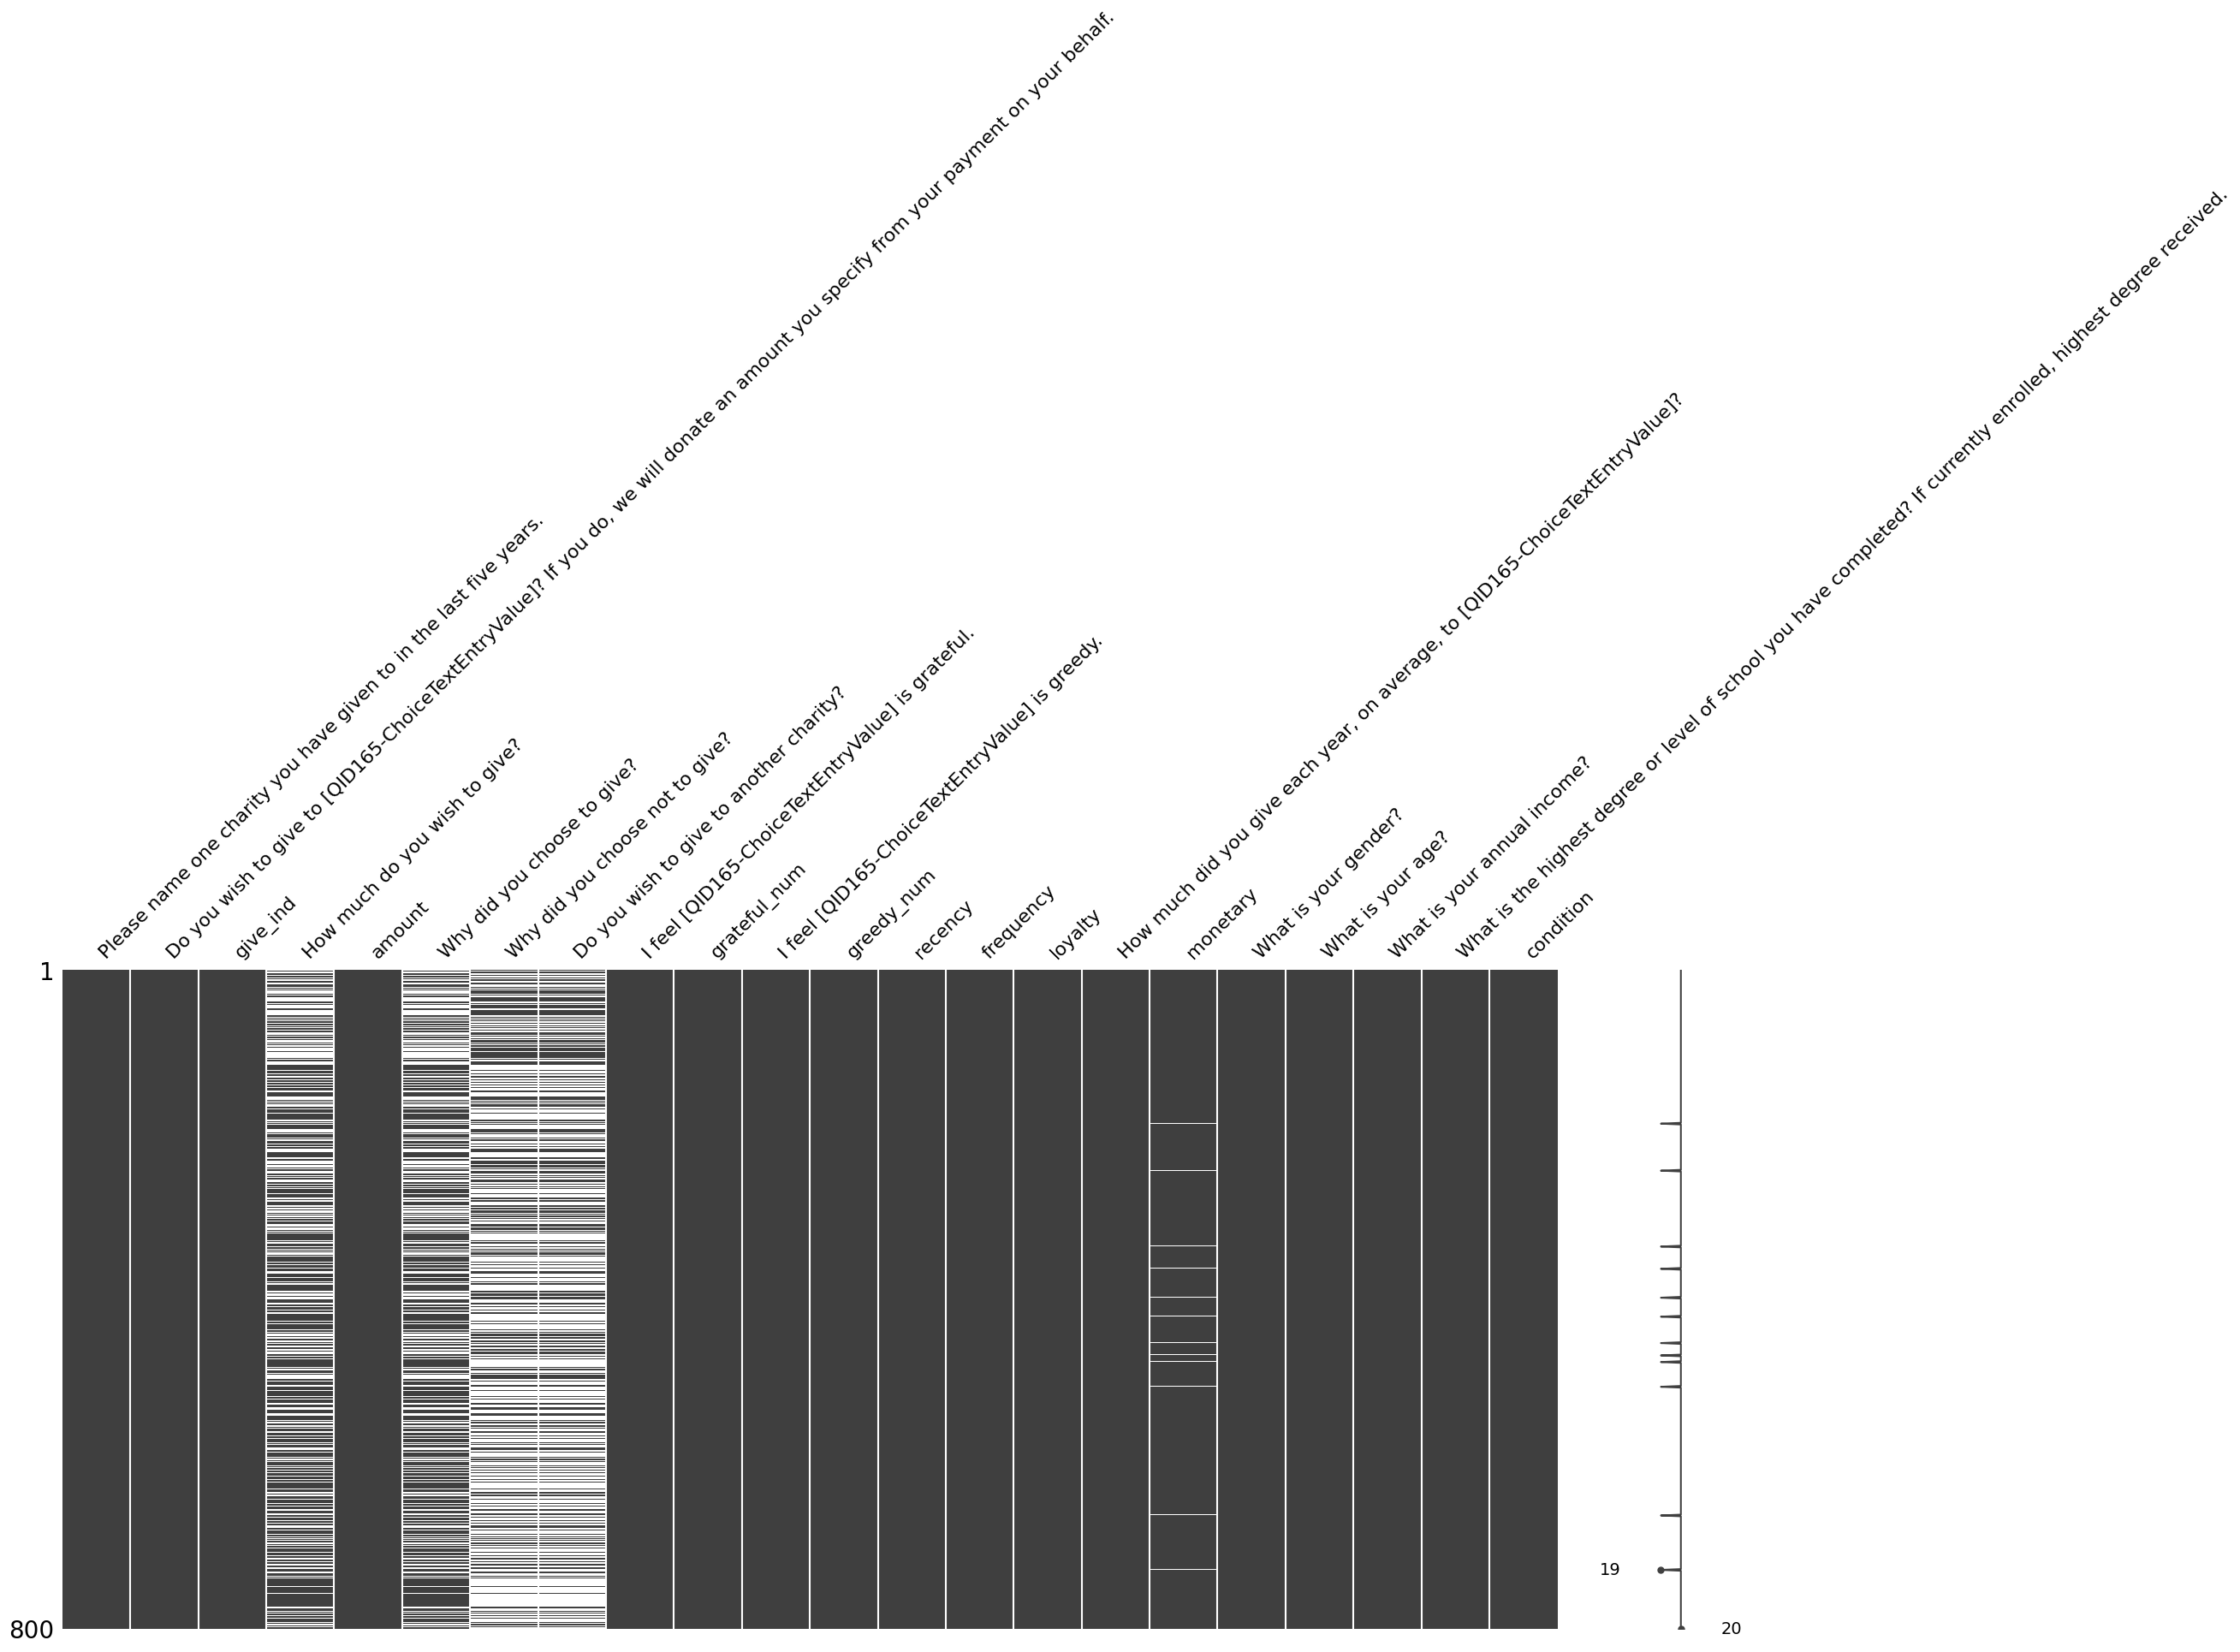

In [62]:
# examine the missing pattern from the graph, we observe four clusters:
# 1. "How much do you wish to give?" can be clustered with "Why did you choose to give?", with same missing pattern
# 2. "Why did you choose not to give?" and "Do you wish to give to another charity?", with the same missing pattern
# 3. "monetary" has a distinct missing pattern
# 4. The rest of the questions, with no missing value
msno.matrix(df);

## c. Observe and understand the relationship between the columns

In [63]:
# check the name of the charities
unique_charities = df["Please name one charity you have given to in the last five years."].unique()
# Print out the unique values, we could observe that there are issues when encoding the data because the same organization has been
# listed with different names in the dataset. For example,
# Red Cross has been listed as "American Red Cross", "Red Cross", "american red cross", "red cross", "American National Red Cross"
# unique_charities

For simplicity, we will just assume that they refer to different organizations. Also we observe that there are several columns that record the same responses. We can remove the some repetitive columns and keep the ones that we are interested in working with <br>
1. "Do you wish to give to [QID165-ChoiceTextEntryValue]? If you do, we will donate an amount you specify from your payment on your behalf." and "give_ind", where 0 indicates no and 1 indicates yes. <br>
2. "I feel [QID165-ChoiceTextEntryValue] is grateful." and "grateful_num". 1 to 5 corresponds to "Strongly disagree", "Disagree", "Neither agree nor disagree", "Agree", "Strongly agree" <br>
3. "I feel [QID165-ChoiceTextEntryValue] is greedy." and "greedy_num" correspond to each other in the same manner as bulletpoint 2. <br>


In [64]:
df = df.drop(columns=["Do you wish to give to [QID165-ChoiceTextEntryValue]? If you do, we will donate an amount you specify from your payment on your behalf.", "grateful_num", "greedy_num"], errors="ignore")

## d. Summary Statistics And Distribution of Data


In [65]:
import string
from wordcloud import WordCloud

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
# the statistics for the numerical data is listed as below
df.describe().drop(columns=['give_ind', 'recency'])

,How much do you wish to give?,amount,frequency,monetary
count,481.000000,800.000000,800.000000,788.000000
mean,0.385031,0.231500,3.030000,250.138325
std,0.157270,0.224601,1.498134,821.438372
min,0.100000,0.000000,1.000000,1.000000
25%,0.300000,0.000000,2.000000,25.000000
50%,0.500000,0.200000,3.000000,75.000000
75%,0.500000,0.500000,5.000000,200.000000
max,0.500000,0.500000,5.000000,12500.000000


In [67]:
df['What is your age?'].unique()

array(['35 - 44', '45 - 54', '25 - 34', '55 - 64', '65 - 74', '18 - 24',
       '75 - 84', '85 or older'], dtype=object)

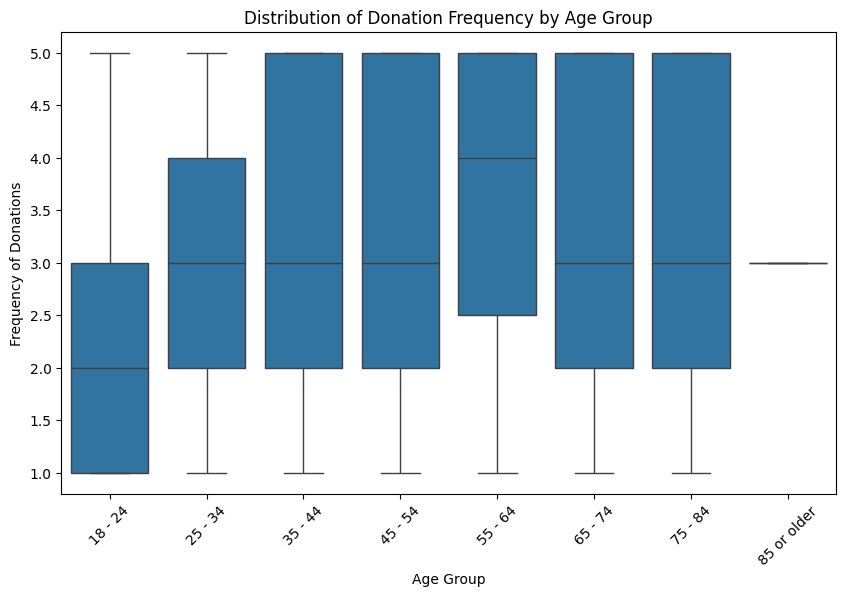

In [68]:
age_order = ['18 - 24', '25 - 34', '35 - 44', '45 - 54',
    '55 - 64', '65 - 74', '75 - 84', '85 or older']
df['What is your age?'] = pd.Categorical(df['What is your age?'], categories=age_order, ordered=True)

# Generating a boxplot to show the distribution of "frequency" across different age groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='What is your age?', y='frequency', data=df)
plt.title('Distribution of Donation Frequency by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Frequency of Donations')
plt.xticks(rotation=45)
plt.show()

I am interested in generating a wordcloud for the two groups

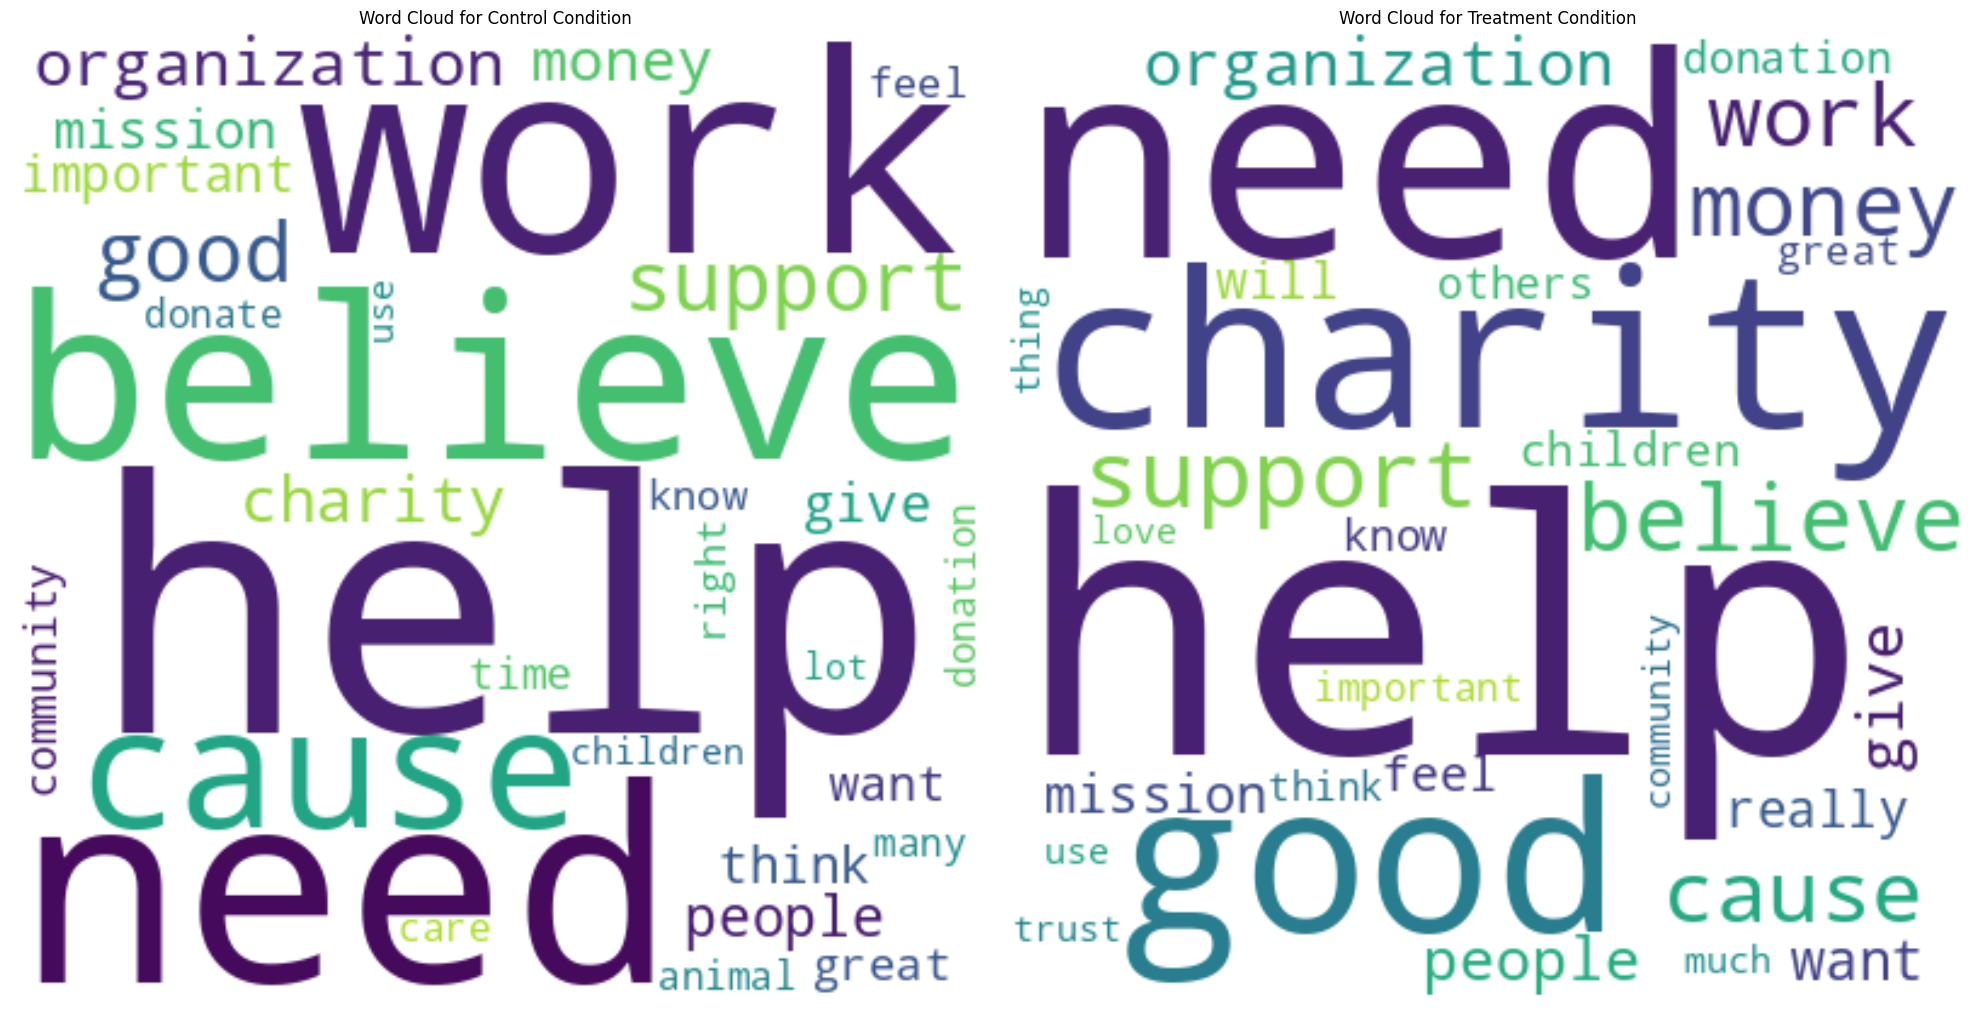

In [69]:
# remove punctuation and lower_case the words
def preprocess_text(text):
    if pd.notnull(text):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
    else:
        text = ""
    return text


df['processed_text'] = df['Why did you choose to give?'].apply(preprocess_text)
grouped_text = df.groupby('condition')['processed_text'].apply(lambda x: ' '.join(x)).reset_index()

# Function to generate and display a word cloud
def generate_wordclouds_side_by_side(grouped_text_df):
    fig, axes = plt.subplots(1, len(grouped_text_df), figsize=(20, 10))
    for ax, (index, row) in zip(axes, grouped_text_df.iterrows()):
        wordcloud = WordCloud(width=400, height=400, max_words=30, random_state=42, background_color='white').generate(row['processed_text'])
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Word Cloud for {row['condition']} Condition")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

generate_wordclouds_side_by_side(grouped_text)

Based on the words in both word clouds. We observe that among people who are willing to donate, we observe that the word "help" and "need" dominate both groups. However, one difference between the two groups is that in the treatment group, the word "good" and "charity" are mentioned more often. While in the control group, the words "believe" and "cause" are mentioned more often.

# 3. Analyze the effect of the experimental treatment on giving (donation) behavior.

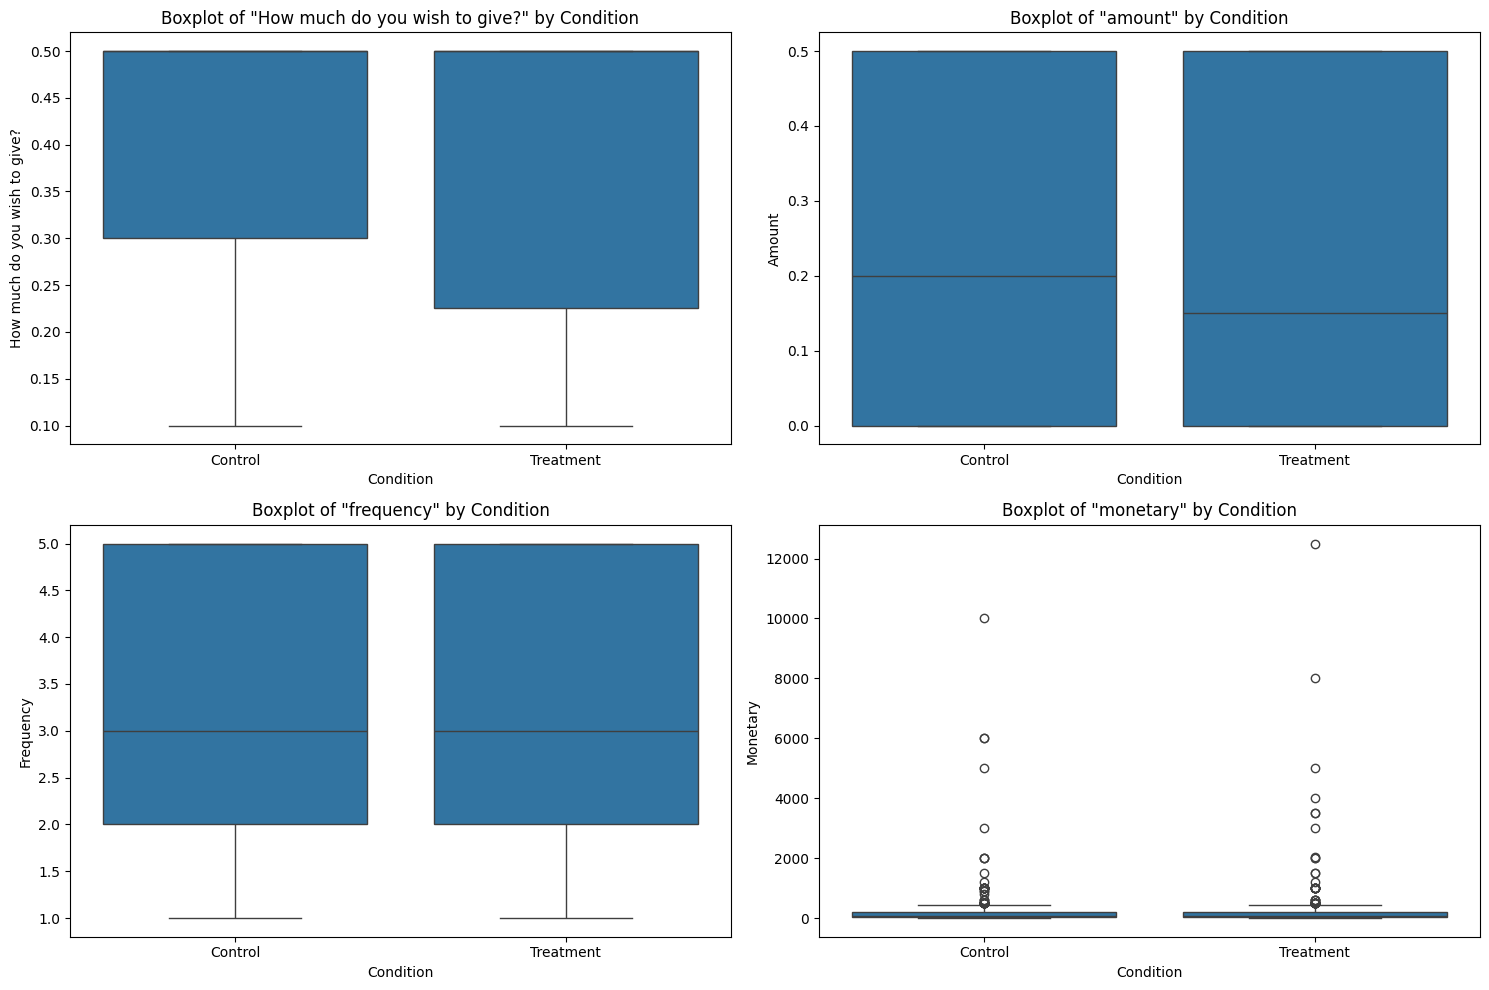

In [70]:
# compare the distribution of the numerical features in both groups
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
columns_to_plot = ['How much do you wish to give?', 'amount', 'frequency', 'monetary']
for ax, column in zip(axs, columns_to_plot):
    sns.boxplot(x='condition', y=column, data=df, ax=ax)
    ax.set_title(f'Boxplot of "{column}" by Condition')
    ax.set_xlabel('Condition')
    ax.set_ylabel(column.capitalize())
plt.tight_layout()
plt.show()

We could observe that the median for the amount that is willing to donate is different between the two groups. Other than that, the distributions for other variables seem very similar between the two distributions. By running t-tests on both amount and how much do you wish to give, we do not observe any significant difference between the two groups. We fail to reject the null hypothesis that the treatment has not effect on the donation behavior.

In [71]:
from scipy.stats import ttest_ind
amount_control = df[df['condition'] == 'Control']['amount']
amount_treatment = df[df['condition'] == 'Treatment']['amount']
t_stat, p_value = ttest_ind(amount_control, amount_treatment)
t_stat, p_value

(0.24828081384872125, 0.8039810192998702)

In [72]:
wish_to_give_control = df[df['condition'] == 'Control']['How much do you wish to give?'].dropna()
wish_to_give_treatment = df[df['condition'] == 'Treatment']['How much do you wish to give?'].dropna()
t_stat, p_value = ttest_ind(wish_to_give_control, wish_to_give_treatment)
t_stat, p_value

(-0.013006078365903586, 0.989628358630219)

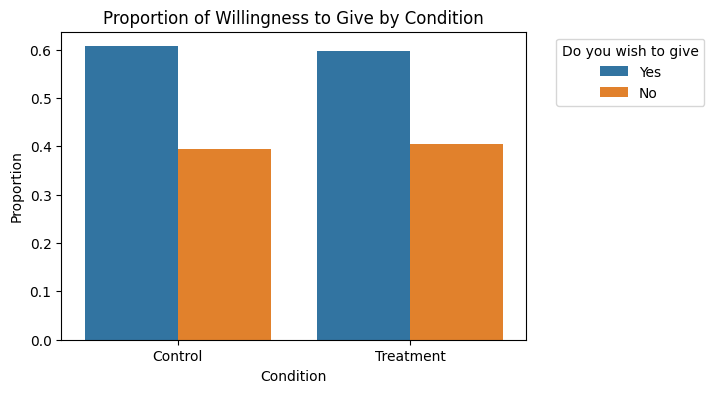

In [73]:
proportion_data_give = df.groupby('condition')['give_ind'].value_counts(normalize=True).rename('proportion').reset_index()
proportion_data_give['give_ind'] = proportion_data_give['give_ind'].map({0: 'No', 1: 'Yes'})
plt.figure(figsize=(6, 4))
sns.barplot(x='condition', y='proportion', hue='give_ind', data=proportion_data_give)
plt.title('Proportion of Willingness to Give by Condition')
plt.xlabel('Condition')
plt.ylabel('Proportion')
plt.legend(title='Do you wish to give',  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

The willingness to give looks very similar across the two experiment group for both "yes" and "no".

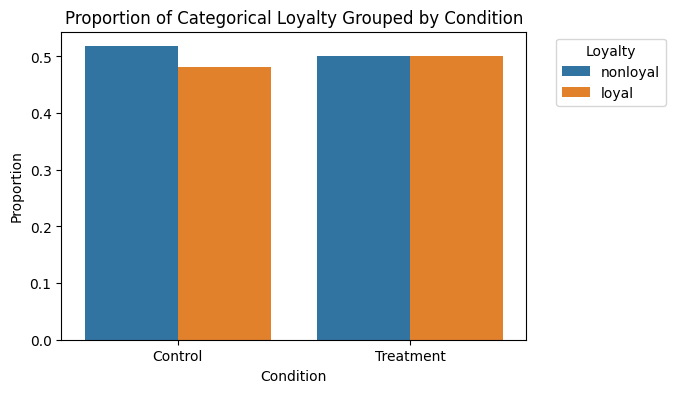

In [74]:
proportion_data = df.groupby('condition')['loyalty'].value_counts(normalize=True).rename('proportion').reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(x='condition', y='proportion', hue='loyalty', data=proportion_data)
plt.title('Proportion of Categorical Loyalty Grouped by Condition')
plt.xlabel('Condition')
plt.ylabel('Proportion')
plt.legend(title='Loyalty', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

It could be observed by the graph that the proportion of not loyal is lower in the treatment group. I want to pick an alpha value of 0.05. Run a chi-square test on the data we observe that the p-value is shown 0.66. We fail to reject our null hypothesis that the treatment group has an effect on the loyalty.

In [75]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['condition'], df['loyalty'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p

(0.1864541659277929, 0.6658843168872766)

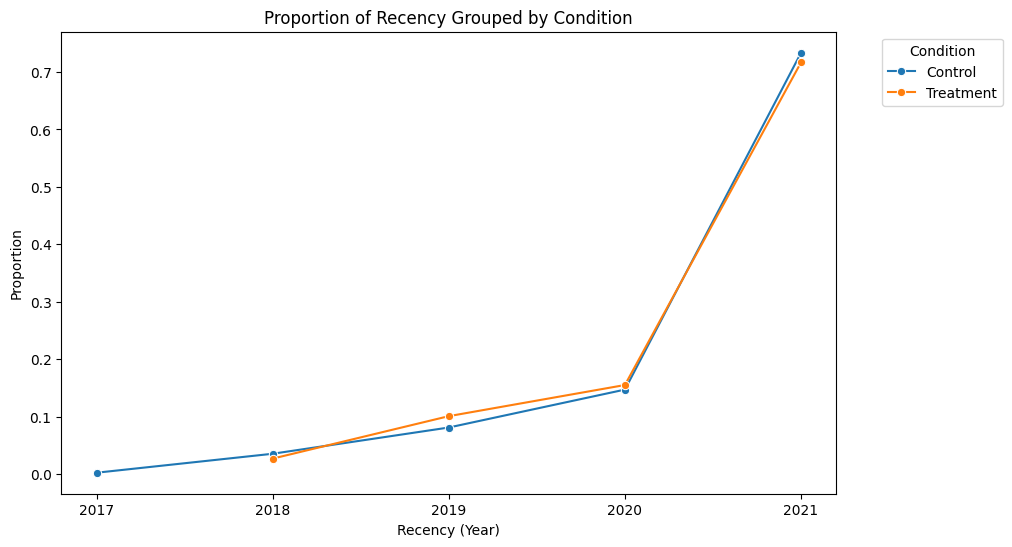

In [76]:
proportion_data = df.groupby('condition')['recency'].value_counts(normalize=True).rename('proportion').reset_index()
proportion_data['recency'] = proportion_data['recency'].astype(str)
proportion_data['recency'] = pd.Categorical(proportion_data['recency'], categories=['2017', '2018', '2019', '2020', '2021'], ordered=True)
plt.figure(figsize=(10, 6))
sns.lineplot(x='recency', y='proportion', hue='condition', data=proportion_data, marker='o')
plt.title('Proportion of Recency Grouped by Condition')
plt.xlabel('Recency (Year)')
plt.ylabel('Proportion')
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=0)  # Optional: Rotate x-axis labels for better readability
plt.show()

We don't observe a great difference between the recency if we exmaine it by condition. In the control group, the proportion of the latest year is slightly higher.

# 4. Analyze how the effect differs across different individuals.

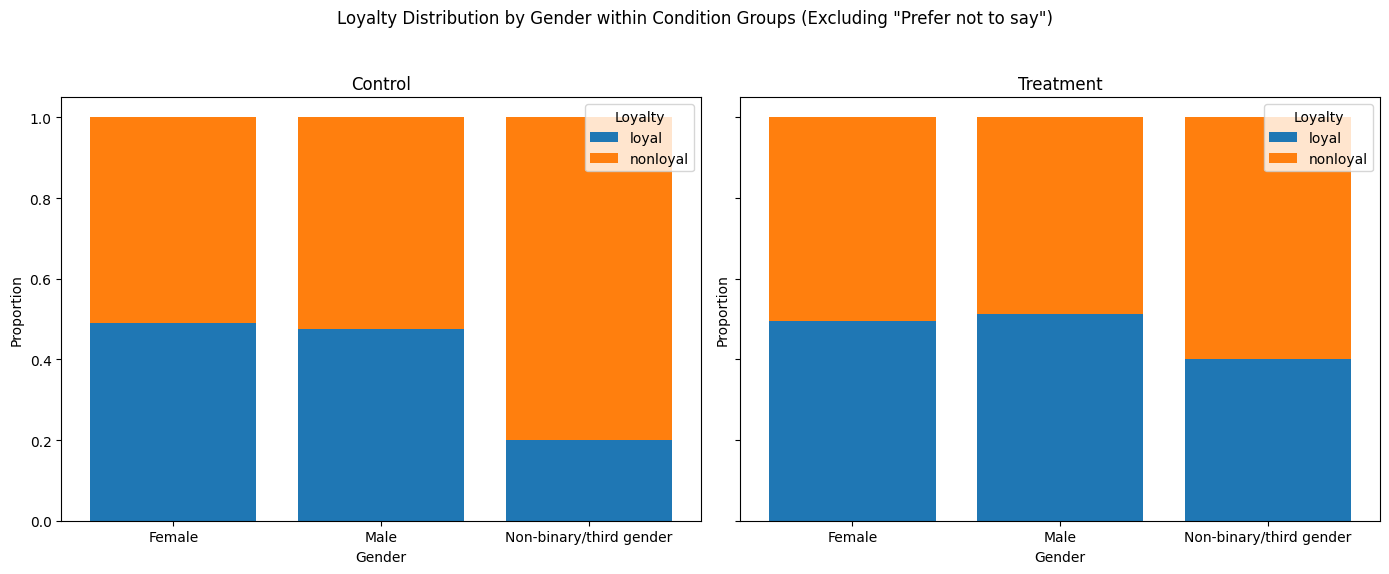

In [78]:
import numpy as np
# filter prefer not to say for better comparison
df_filtered = df[df['What is your gender?'] != 'Prefer not to say']

# create graphs to compare the distributions between the two groups
proportion_data_gender_filtered = df_filtered.groupby(['condition', 'What is your gender?'])['loyalty'] \
                                              .value_counts(normalize=True) \
                                              .rename('proportion') \
                                              .reset_index()
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle('Loyalty Distribution by Gender within Condition Groups (Excluding "Prefer not to say")')

for ax, (condition, group_data) in zip(axes, proportion_data_gender_filtered.groupby('condition')):
    condition_data_pivot = group_data.pivot_table(index='What is your gender?', columns='loyalty', values='proportion').fillna(0)
    bottom_value = np.zeros(len(condition_data_pivot))

    for loyalty_level in condition_data_pivot.columns:
        ax.bar(condition_data_pivot.index, condition_data_pivot[loyalty_level], bottom=bottom_value, label=f'{loyalty_level}')
        bottom_value += condition_data_pivot[loyalty_level].values

    ax.set_title(condition)
    ax.set_xlabel('Gender')
    ax.set_ylabel('Proportion')
    ax.legend(title='Loyalty')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

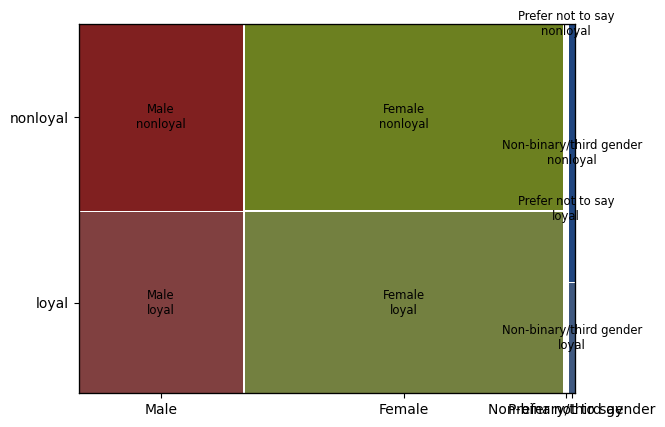

In [79]:
# generate the plot, we understand that gender does not bring hetergenous to account for the difference
# in the loyal distribution
mosaic(df, ['What is your gender?','loyalty']);

In [80]:
# due to the small sample size, we this difference is likely due to sysmeatic difference instead of actual effect
# from treatment group
df_nonbinary = df_filtered[df_filtered['What is your gender?'] == 'Non-binary/third gender']
contingency_table_nonbinary = pd.crosstab(df_nonbinary['condition'], df_nonbinary['loyalty'])
# Performing the Chi-square test for independence
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_nonbinary)
chi2_stat, p_value, contingency_table_nonbinary

(0.0,
 1.0,
 loyalty    loyal  nonloyal
 condition                 
 Control        1         4
 Treatment      2         3)

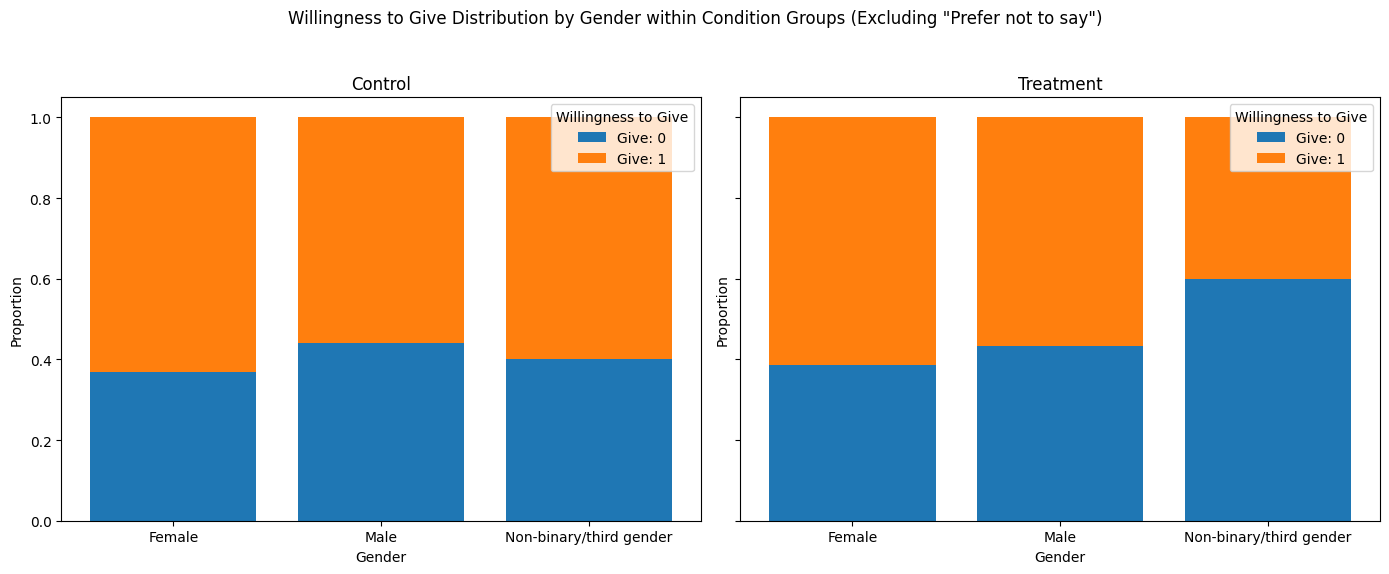

In [81]:
proportion_data_give_ind_filtered = df_filtered.groupby(['condition', 'What is your gender?'])['give_ind'] \
                                                .value_counts(normalize=True) \
                                                .rename('proportion') \
                                                .reset_index()

# Creating the subplots for "give_ind" distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle('Willingness to Give Distribution by Gender within Condition Groups (Excluding "Prefer not to say")')

for ax, (condition, group_data) in zip(axes, proportion_data_give_ind_filtered.groupby('condition')):
    condition_data_pivot = group_data.pivot_table(index='What is your gender?', columns='give_ind', values='proportion').fillna(0)
    bottom_value = np.zeros(len(condition_data_pivot))

    for give_ind_level in condition_data_pivot.columns:
        ax.bar(condition_data_pivot.index, condition_data_pivot[give_ind_level], bottom=bottom_value, label=f'Give: {give_ind_level}')
        bottom_value += condition_data_pivot[give_ind_level].values

    ax.set_title(condition)
    ax.set_xlabel('Gender')
    ax.set_ylabel('Proportion')
    ax.legend(title='Willingness to Give')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


the distribtuion regarding willingness to give is the same

<ipython-input-82-cfd130f27cb4>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(condition_data_pivot.index, rotation=45)
<ipython-input-82-cfd130f27cb4>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(condition_data_pivot.index, rotation=45)


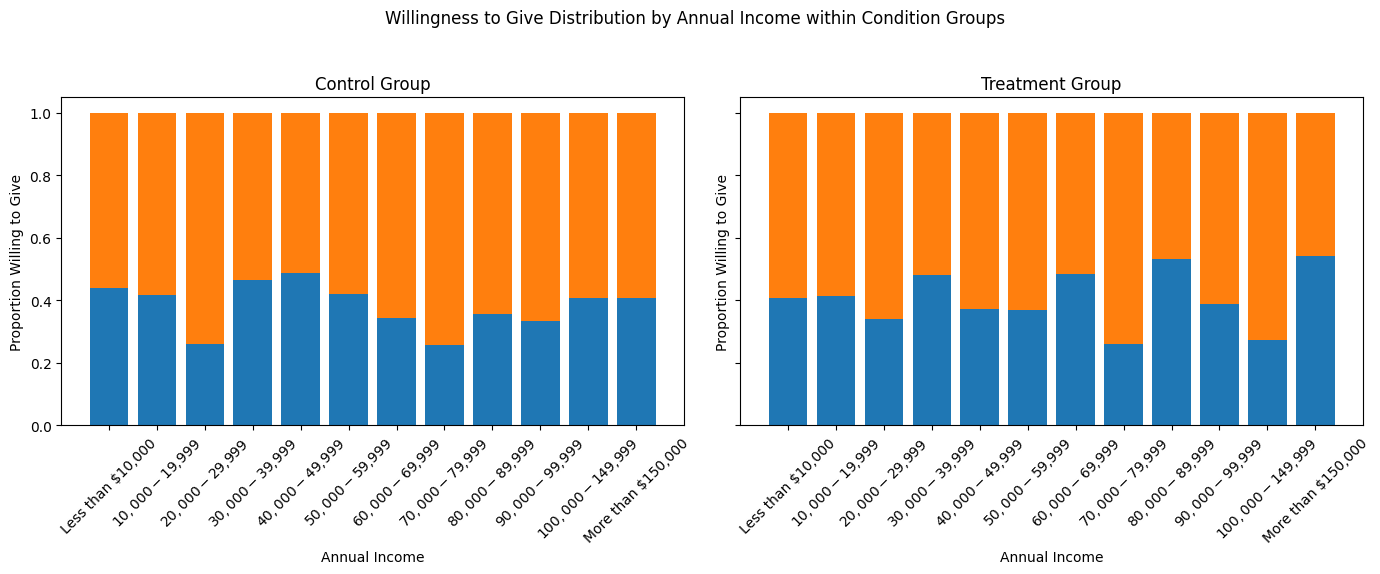

In [82]:
income_order = [
    'Less than $10,000', '$10,000 - $19,999', '$20,000 - $29,999',
    '$30,000 - $39,999', '$40,000 - $49,999', '$50,000 - $59,999',
    '$60,000 - $69,999', '$70,000 - $79,999', '$80,000 - $89,999',
    '$90,000 - $99,999', '$100,000 - $149,999', 'More than $150,000'
]

df['What is your annual income?'] = pd.Categorical(df['What is your annual income?'], categories=income_order, ordered=True)
proportion_data_income_filtered = df.groupby(['condition', 'What is your annual income?'])['give_ind'] \
                                     .value_counts(normalize=True) \
                                     .rename('proportion') \
                                     .reset_index()

# Creating the subplots for the reordered scale
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle('Willingness to Give Distribution by Annual Income within Condition Groups')

for ax, (condition, group_data) in zip(axes, proportion_data_income_filtered.groupby('condition')):
    condition_data_pivot = group_data.pivot_table(index='What is your annual income?', columns='give_ind', values='proportion', aggfunc='sum').reindex(income_order).fillna(0)
    bottom_value = np.zeros(len(condition_data_pivot))

    for give_ind_level in condition_data_pivot.columns:
        ax.bar(condition_data_pivot.index, condition_data_pivot[give_ind_level], bottom=bottom_value, label=f'Give: {give_ind_level}')
        bottom_value += condition_data_pivot[give_ind_level].values

    ax.set_title(f'{condition} Group')
    ax.set_xlabel('Annual Income')
    ax.set_ylabel('Proportion Willing to Give')
    ax.set_xticklabels(condition_data_pivot.index, rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


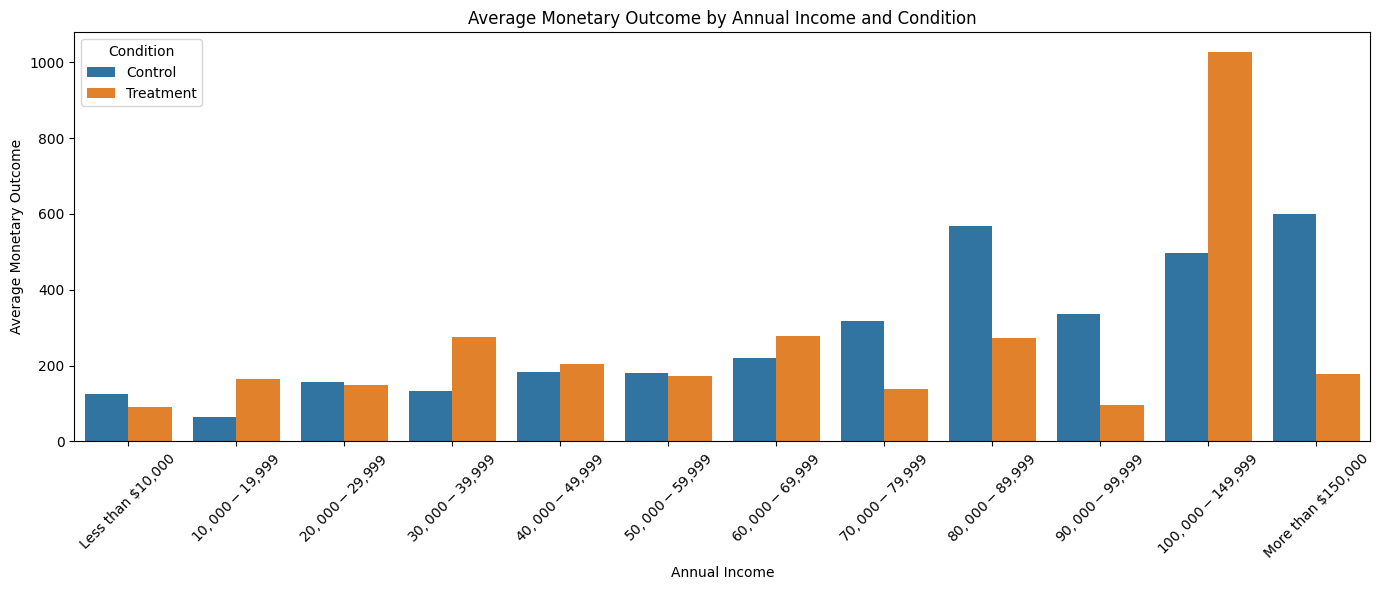

In [83]:
df['What is your annual income?'] = pd.Categorical(df['What is your annual income?'], categories=income_order, ordered=True)
grouped_data_ordered = df_filtered.groupby(['What is your annual income?', 'condition'])['monetary'].mean().reset_index()
plt.figure(figsize=(14, 6))
sns.barplot(x='What is your annual income?', y='monetary', hue='condition', data=grouped_data_ordered, order=income_order)
plt.title('Average Monetary Outcome by Annual Income and Condition')
plt.xlabel('Annual Income')
plt.ylabel('Average Monetary Outcome')
plt.xticks(rotation=45)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

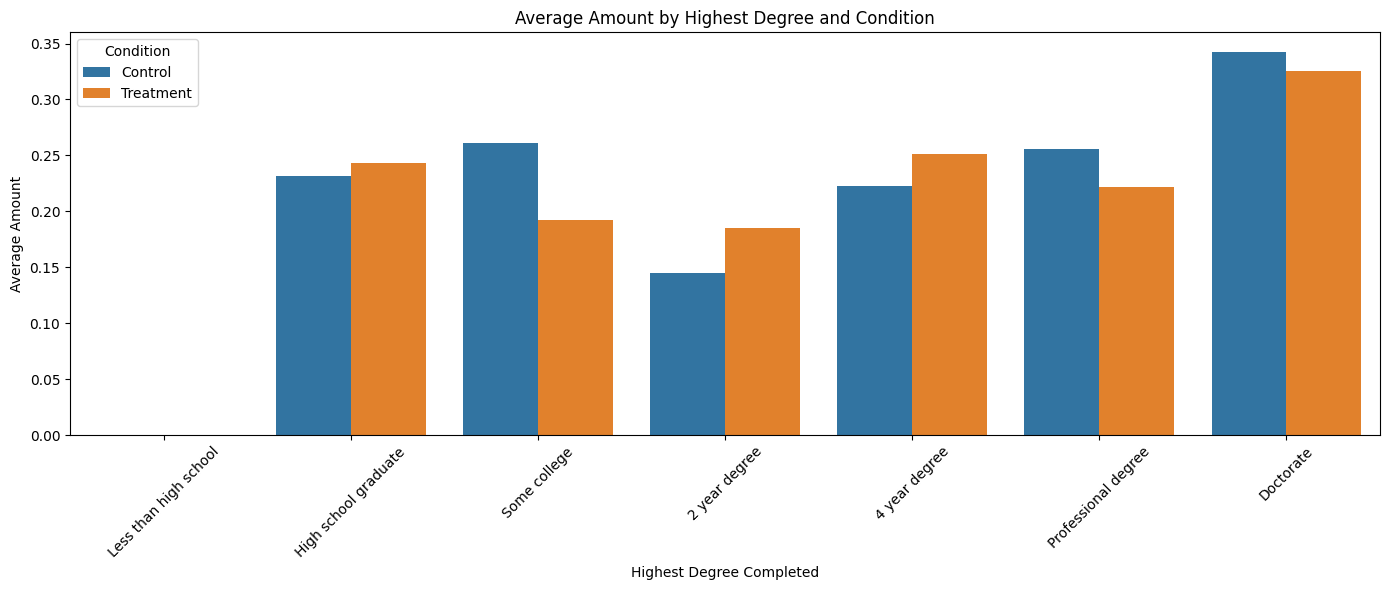

In [84]:
education_order = [
    'Less than high school',
    'High school graduate',
    'Some college',
    '2 year degree',
    '4 year degree',
    'Professional degree',
    'Doctorate'
]
df['Highest Degree'] = df['What is the highest degree or level of school you have completed? If currently enrolled, highest degree received.']
df['Highest Degree'] = pd.Categorical(df['Highest Degree'], categories=education_order, ordered=True)
grouped_data_education = df.groupby(['Highest Degree', 'condition'])['amount'].mean().reset_index()
plt.figure(figsize=(14, 6))
sns.barplot(x='Highest Degree', y='amount', hue='condition', data=grouped_data_education, order=education_order)
plt.title('Average Amount by Highest Degree and Condition')
plt.xlabel('Highest Degree Completed')
plt.ylabel('Average Amount')
plt.xticks(rotation=45)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

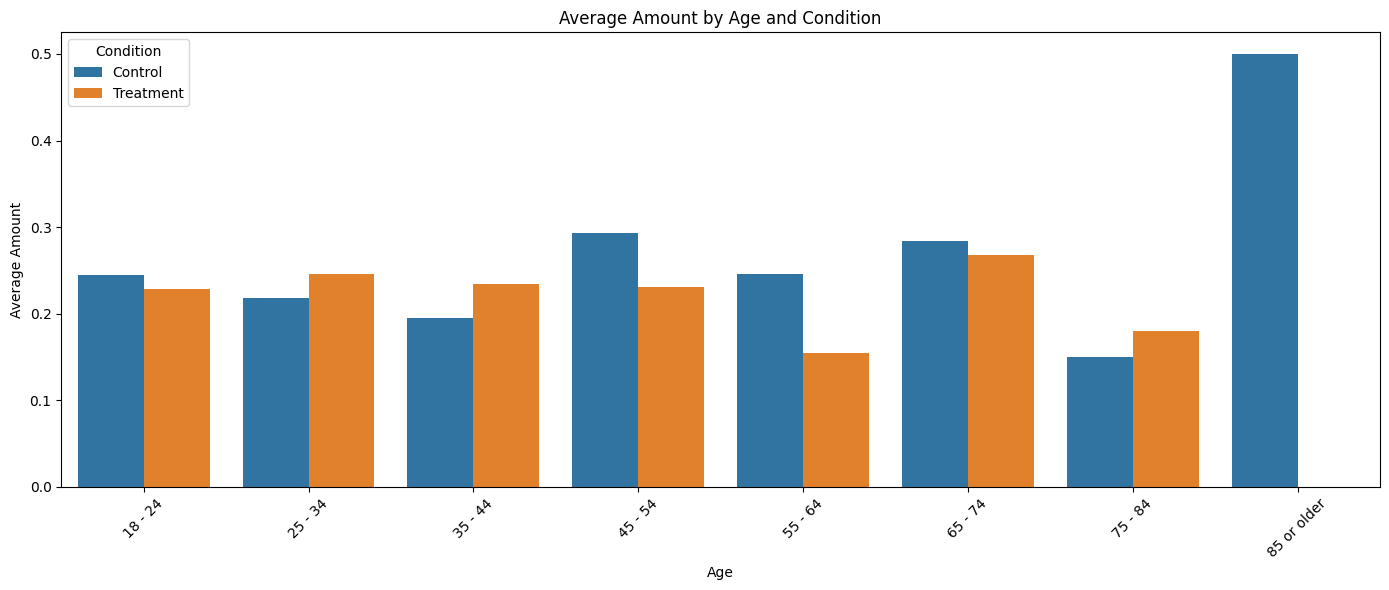

In [85]:
grouped_data_age = df.groupby(['What is your age?', 'condition'])['amount'].mean().reset_index()
plt.figure(figsize=(14, 6))
sns.barplot(x='What is your age?', y='amount', hue='condition', data=grouped_data_age)
plt.title('Average Amount by Age and Condition')
plt.xlabel('Age')
plt.ylabel('Average Amount')
plt.xticks(rotation=45)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()